# Test Data Analysis
Just messin around

In [1]:
# Install libraries
%pip install firebase_admin google-cloud-firestore pandas matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Firebase setup

import firebase_admin
from firebase_admin import credentials, firestore

cred = credentials.Certificate("secrets/firebase_key.json")
firebase_admin.initialize_app(cred)

db = firestore.client()

In [3]:
# Get user data

import firebase_admin
from firebase_admin import auth

email = "alexxander1611@gmail.com"

user = auth.get_user_by_email(email)
print(f'Successfully fetched user data: {user.uid}')

user_info = db.collection('Users').document(user.uid).get().to_dict()
print(user_info)


Successfully fetched user data: hiZJsylQKJNitULApBf4e9XH9vg1


E0000 00:00:1760741624.856593  621117 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


{'email': 'Alexxander1611@gmail.com', 'uid': 'hiZJsylQKJNitULApBf4e9XH9vg1'}


In [55]:
# Fetch IMU data

import pandas as pd

imu_coll = db.collection('UserIMU').document(user.uid).collection('Sessions')
query = imu_coll.order_by("time", direction=firestore.Query.DESCENDING).limit(1)
user_imu = query.get()[0].to_dict()

rows = []

for device, device_data in user_imu['data'].items():
	for imu_function,data in device_data.items():
		segmentIdx = 0
		for segment in data.values():
			for entry in segment:
				for simd in entry['list']:
					entry = {}
					entry["Device"] = device
					entry['Type'] = imu_function 
					entry['Time'] = simd['readTime']
					entry['Segment'] = segmentIdx
					entry["X"] = simd['read'][0]
					entry["Y"] = simd['read'][1]
					entry["Z"] = simd['read'][2]
					entry['Timestamp'] = user_imu['time']
					rows.append(entry)
			segmentIdx += 1
df = pd.DataFrame(rows)
df

,Device,Type,Time,Segment,X,Y,Z,Timestamp
0,Alpha ,mag,1.760742e+09,0,0.000000,0.000000,0.000000,1.760742e+09
1,Alpha ,mag,1.760742e+09,0,0.000000,0.000000,0.000000,1.760742e+09
2,Alpha ,mag,1.760742e+09,0,0.000000,0.000000,0.000000,1.760742e+09
3,Alpha ,mag,1.760742e+09,0,0.000000,0.000000,0.000000,1.760742e+09
4,Alpha ,mag,1.760742e+09,0,0.000000,0.000000,0.000000,1.760742e+09
...,...,...,...,...,...,...,...,...
142,Alpha ,planar,1.760742e+09,0,2.954445,0.488417,9.466674,1.760742e+09
143,Alpha ,planar,1.760742e+09,0,2.645593,0.440533,8.848969,1.760742e+09
144,Alpha ,planar,1.760742e+09,0,2.712631,0.440533,9.133880,1.760742e+09
145,Alpha ,planar,1.760742e+09,0,3.263297,0.457293,9.301474,1.760742e+09


In [56]:
# Visualize IMU data of a given type

devname = "Alpha\x00"
imutype = "planar"

dev = df[df['Type'] == imutype].copy()
dev = dev[dev['Device'] == devname].copy()
earliest = dev['Time'].min()
dev['Elapsed'] = dev['Time'] - earliest

dev.head()

,Device,Type,Time,Segment,X,Y,Z,Timestamp,Elapsed
98,Alpha ,planar,1.760742e+09,0,-0.457293,-0.711078,9.694122,1.760742e+09,0.000000
99,Alpha ,planar,1.760742e+09,0,-0.356736,-0.754174,9.744401,1.760742e+09,0.118592
100,Alpha ,planar,1.760742e+09,0,-0.215478,-0.622492,9.670180,1.760742e+09,0.300149
101,Alpha ,planar,1.760742e+09,0,-0.545878,-1.082179,9.744401,1.760742e+09,0.510753
102,Alpha ,planar,1.760742e+09,0,0.232238,-0.035913,9.777920,1.760742e+09,0.688989


/Users/callum/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


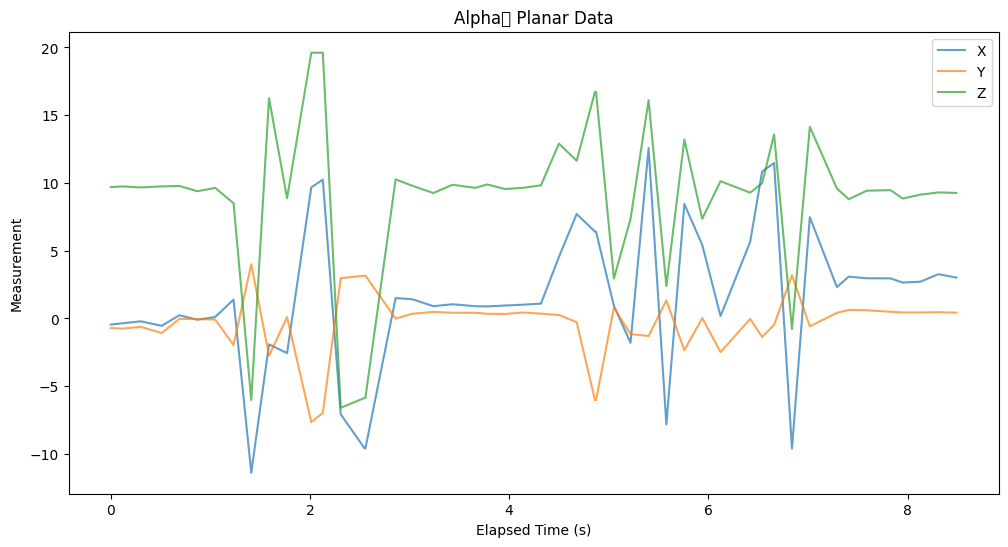

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dev['Elapsed'], dev['X'], label='X', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Y'], label='Y', alpha=0.7)
plt.plot(dev['Elapsed'], dev['Z'], label='Z', alpha=0.7)
plt.title(devname + ' ' + (imutype[0].upper() + imutype[1:]) + ' Data')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Measurement')
plt.legend()
plt.show()

Copyright © 2025 Callum Mackenzie